In [2]:
%load_ext tikzmagic
%matplotlib inline

In [3]:
import os
import sys
from collections import namedtuple

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from colormaps import viridis  # DEATH TO JET!

# Add my Python utils to the path
sys.path.append(os.path.join('..', 'Sean', 'py_utils'))

from pgm import read_pgm
from raw import read_raw

# Neural Network Image Processing for the JPL Space Design Competition

## or: How I Learned to Stop Worrying and Love the Net

---

https://wiki.cites.illinois.edu/wiki/display/jplteam

April, 2015, the aerospace department hosted a competition put on in conjunction with the NASA Jet Propulsion Laboratory which asked students to build an algorithm to identify safe landing zones on a series of hypothetical planetary surfaces given a limited set of overhead images and terrain data.  While this sort of task is very important for NASA, nearly identical classification tasks can easily by construction for other industrial applications, such as landing drones (think Amazon drone delivery).

Because this is a classification problem with a large component being image processing, we figured machine learning would be very well suited.  We have in this problem a clear set of geometric constraints, and at the outset, we were unsure if we could construct an algorithm that would be able to handle all of the different constraints.

In [4]:
# Define the locations of things
train_dir = os.path.join("..", "training data", "terrainS{slope}C{crater}R{rough}_100")
pgm_file = os.path.join(train_dir, "terrainS{slope}C{crater}R{rough}_100.pgm")
raw_file = os.path.join(train_dir, "terrainS{slope}C{crater}R{rough}_100_500by500_dem.raw")
soln_file = os.path.join(train_dir, "terrainS{slope}C{crater}R{rough}_100.invHazard.pgm")

difficulty = namedtuple("Difficulty", ["slope", "crater", "roughness"])
diffs = list(map(lambda x: difficulty(*x), [(0, 0, 10), (4, 0, 10), (4, 4, 10), (4, 4, 20)]))

# Problem

**Can we use neural networks to identify "safe" landing sites on a planetary surface?**

For each potential landing site (100 m x 100 m), we are given two sets of data:

2. The terrain height, with a resolution of 0.2 m (500x500 pixels)

1. An overhead image of the landing site, with the sun from the east at 30° above the horizon, with a resolution of 0.1 m (1000x1000 pixels)

In this scenario, this data would correspond to a coarse satelite imaging of the surface and a snapshot taken by the rover during the descent, respectively.  Because of the relatively low sampling density, brute forcing the problem from the height data alone is not sufficient, we need some intelligent data processing scheme.

From these two sets of data, we must construct a corresponding 1000x1000 pixel map of acceptable landing locations.

## Geometric Constraints

The rover that we must consider is one with the following dimensions:
![](lander.svg)

For a given location to be considered safe, the rover must be able to land safely in all rotational configurations about its center.

There are two key constraints that disqualify a potential landing zone:

### Slope hazards

If the landing spot of the rover is at too great a slope, the rover runs the risk of toppling over. The maximum allowed tilt from vertical is 10°.

![](slope_hazard.svg)

### Roughness hazards

There must be nothing below the rover that will make contact with the lower base of the rover, so there must be clearance over any rock or similar hazard.

![](roughness_hazard.svg)

----

# Provided Information

* 4 Training sets of varying difficulty

Easiest only has roughness hazards (rocks), then slopes, craters, and additional roghness are added in succession for the rest of the data sets.  For each data set, the height and image data, as noted above, are provided, in addition to the correct solution.

The algorithm is judged on its ability to solve not only the provided sets of data, but another batch of 4 data sets on the day of the competition.

## Height Data

In [5]:
vmax = max(np.max(read_raw(raw_file.format(slope=d.slope, crater=d.crater, rough=d.roughness), 500, 500)) for d in diffs)
vmin = min(np.min(read_raw(raw_file.format(slope=d.slope, crater=d.crater, rough=d.roughness), 500, 500)) for d in diffs)

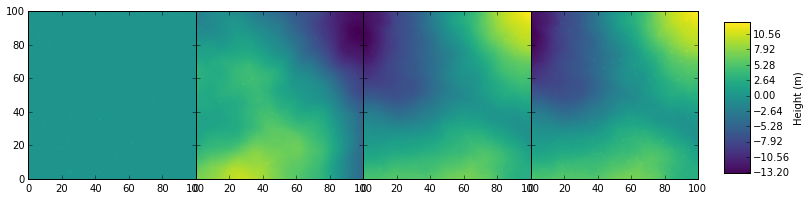

In [6]:
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True)
fig.set_size_inches(12., 3)

x = np.linspace(0, 100, 500)
X, Y = np.meshgrid(x, x)

for i, d in enumerate(diffs):
    # Here's the data we'll plot
    raw = read_raw(raw_file.format(slope=d.slope, crater=d.crater, rough=d.roughness), 500, 500)
    
    ax = axs.flatten()[i]
    
    cf = ax.contourf(X, Y, raw, 500, cmap=viridis, vmax=vmax, vmin=vmin)
    
    ax.set_aspect('equal')
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)

fig.subplots_adjust(hspace=0, wspace=0, right=0.9)
cb_ax = fig.add_axes([0.93, 0.15, 0.03, 0.7])
cb = fig.colorbar(cf, cax=cb_ax)
cb.set_label('Height (m)')

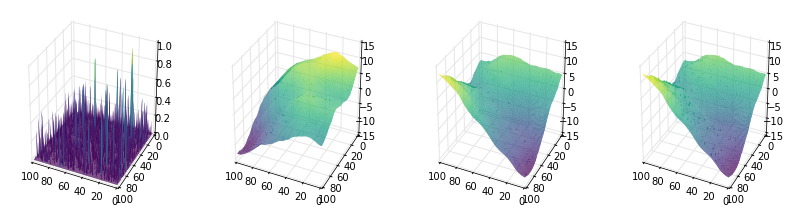

In [7]:
fig = plt.figure()
fig.set_size_inches(14, 3.5)

x = np.linspace(0, 100, 500)
X, Y = np.meshgrid(x, x)

for i, d in enumerate(diffs):
    # Here's the data we'll plot
    raw = read_raw(raw_file.format(slope=d.slope, crater=d.crater, rough=d.roughness), 500, 500)

    ax = fig.add_subplot(1, 4, i + 1, projection='3d')
    ax.plot_surface(X, Y, raw, rstride=4, cstride=4, cmap=viridis, lw=0) #, vmax=vmax, vmin=vmin)
    
    ax.w_xaxis.pane.set_visible(False)
    ax.w_yaxis.pane.set_visible(False)
    ax.w_zaxis.pane.set_visible(False)
    
    ax.view_init(azim=115)

## Image data

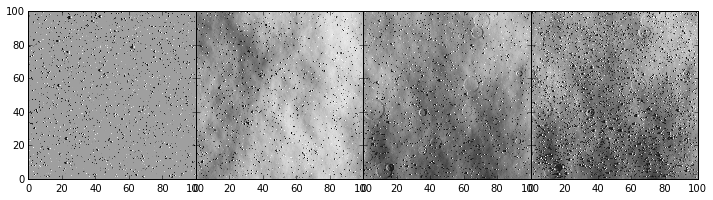

In [8]:
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 3)

for i, d in enumerate(diffs):
    # Here's the data we'll plot
    pgm = read_pgm(pgm_file.format(slope=d.slope, crater=d.crater, rough=d.roughness))
    
    ax = axs.flatten()[i]
    ax.imshow(pgm, cmap=mpl.cm.gray, extent=(0, 100, 0, 100))
    
fig.subplots_adjust(hspace=0, wspace=0)

## Solutions

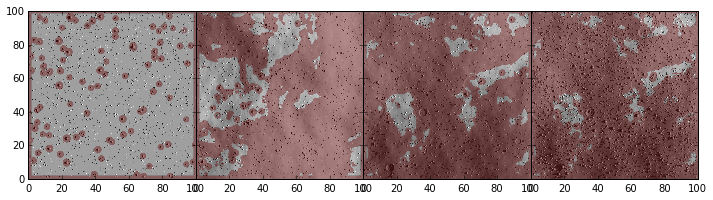

In [9]:
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 3)

for i, d in enumerate(diffs):
    pgm = read_pgm(pgm_file.format(slope=d.slope, crater=d.crater, rough=d.roughness))
    soln = read_pgm(soln_file.format(slope=d.slope, crater=d.crater, rough=d.roughness))
    
    soln_overlay = np.ones((soln.shape[0], soln.shape[1], 4), dtype=np.uint8) * 255
    soln_overlay[:,:,2] = soln_overlay[:,:,1] = soln  # make it red
    soln_overlay[:,:,3] = (255 - soln) * 0.4  # only color red, with alpha mask
    
    ax = axs.flatten()[i]
    ax.imshow(pgm, cmap=mpl.cm.gray, extent=(0, 100, 0, 100))
    ax.imshow(soln_overlay, extent=(0, 100, 0, 100))
    
fig.subplots_adjust(hspace=0, wspace=0)

# Neural Network Basics

For our problem, we must take a set of input data, namely the height and image data about a particular landing site, and use that to classify if we can safely land in that location. To do this, we use a neural network.

In the most simple form (no activation function, zero bias), a neural network is a fancy way of saying a complex linear mapping. That is to say we take our set of input parameters as a vector and multiply it by a matrix to map it onto the space of possible outputs, that is "safe" and "unsafe".

In [16]:
%%tikz
\node (1) {1};

No image generated.


In [17]:
%tikz \draw (0,0) rectangle (1,1);

No image generated.
